# Customer Churn Prediction — Machine Learning Project

This notebook predicts customer churn for a telecom company using Python and machine learning.  
It covers data cleaning, exploratory data analysis (EDA), class balancing using SMOTE, model training, and business insights.


In [94]:
import pandas as pd

df = pd.read_csv(r"C:\Users\User\customer-churn-prediction\data\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Data Loading & Cleaning

This section loads the Telco Customer Churn dataset and performs initial cleaning:
- Convert `TotalCharges` from string to numeric  
- Handle missing values  
- Convert `SeniorCitizen` to categorical  
- Remove invalid or empty rows  

These steps prepare the dataset for analysis and modeling.


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [96]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", pd.NA)
df["TotalCharges"] = df["TotalCharges"].astype(float)


TypeError: float() argument must be a string or a real number, not 'NAType'

In [121]:
import numpy as np

# show some problematic rows so you see what's happening
print("unique examples (first 20):", df["TotalCharges"].unique()[:20])

# replace blanks or pure whitespace with NaN first (covers " " or "")
df["TotalCharges"] = df["TotalCharges"].replace(r'^\s*$', np.nan, regex=True)

# convert to numeric safely
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# confirm dtype and missing count
print("dtype:", df["TotalCharges"].dtype)
print("missing in TotalCharges:", df["TotalCharges"].isna().sum())


unique examples (first 20): ['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95' '587.45' '326.8' '5681.1' '5036.3' '2686.05'
 '7895.15' '1022.95' '7382.25' '528.35' '1862.9']
dtype: float64
missing in TotalCharges: 11


In [123]:
# inspect rows with missing TotalCharges if you want to confirm
missing_rows = df[df["TotalCharges"].isna()]
print("rows with missing TotalCharges:", missing_rows.shape[0])
missing_rows.head()

# drop them (they are usually very few)
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)
print("new shape after dropping missing TotalCharges:", df.shape)


rows with missing TotalCharges: 11
new shape after dropping missing TotalCharges: (7032, 21)


In [125]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")
df.info()   # quick sanity check for dtypes and remaining nulls


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [127]:
# check class balance for target
print(df["Churn"].value_counts())
# summary stats for numeric columns
print(df[["tenure","MonthlyCharges","TotalCharges"]].describe().round(2))


Churn
No     5163
Yes    1869
Name: count, dtype: int64
        tenure  MonthlyCharges  TotalCharges
count  7032.00         7032.00       7032.00
mean     32.42           64.80       2283.30
std      24.55           30.09       2266.77
min       1.00           18.25         18.80
25%       9.00           35.59        401.45
50%      29.00           70.35       1397.48
75%      55.00           89.86       3794.74
max      72.00          118.75       8684.80


In [129]:
# Drop customerID — it does not help prediction
df_model = df.drop("customerID", axis=1)

# Convert target to binary (Yes = 1, No = 0)
df_model["Churn"] = df_model["Churn"].map({"Yes": 1, "No": 0})

# One-hot encode all remaining categorical columns
df_encoded = pd.get_dummies(df_model, drop_first=True)

df_encoded.head()


,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [131]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((5625, 30), (1407, 30))

In [133]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8017057569296375

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.57      0.60       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


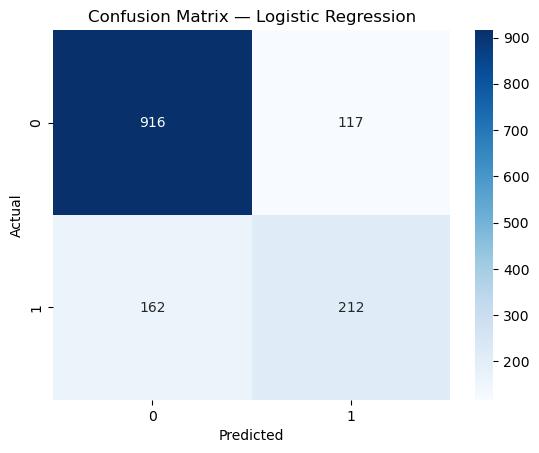

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7882018479033405

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [139]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.7782515991471215

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.52      0.56       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407



In [141]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_res, y_res = smote.fit_resample(X, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", y_res.value_counts())


Before SMOTE: Churn
0    5163
1    1869
Name: count, dtype: int64
After SMOTE: Churn
0    5163
1    5163
Name: count, dtype: int64


In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    random_state=42,
    stratify=y_res
)

X_train.shape, X_test.shape


((8260, 30), (2066, 30))

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_balanced = LogisticRegression(max_iter=2000)
log_balanced.fit(X_train, y_train)

y_pred_log_bal = log_balanced.predict(X_test)

print("Balanced Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_bal))


Balanced Logistic Regression Accuracy: 0.829622458857696

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      1033
           1       0.82      0.85      0.83      1033

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066



C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [147]:
from xgboost import XGBClassifier

xgb_bal = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_bal.fit(X_train, y_train)
y_pred_xgb_bal = xgb_bal.predict(X_test)

print("Balanced XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_bal))


Balanced XGBoost Accuracy: 0.8344627299128751

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1033
           1       0.82      0.85      0.84      1033

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066



## 2. Exploratory Data Analysis (EDA)

The goal of EDA is to understand patterns associated with customer churn.  
The following visualizations are included:

1. Churn distribution  
2. Tenure vs Churn  
3. Monthly Charges vs Churn  
4. Contract Type vs Churn  
5. Internet Service vs Churn  
6. Payment Method vs Churn  


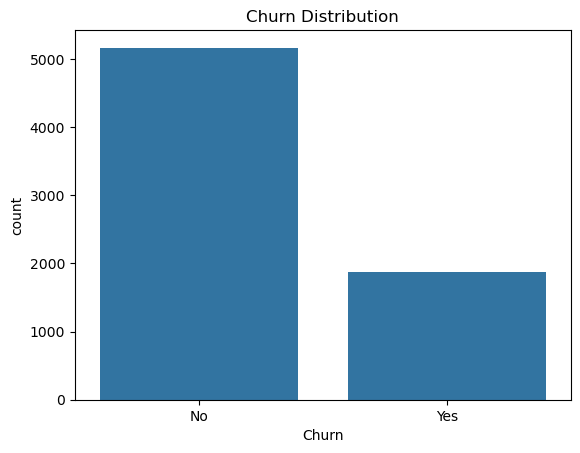

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()


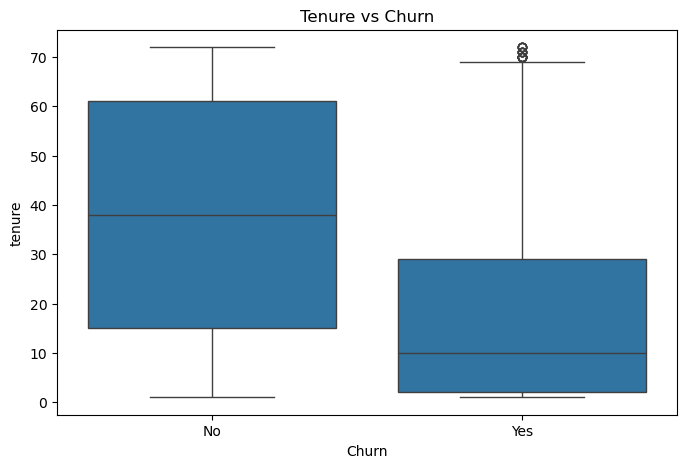

In [151]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Churn', y='tenure')
plt.title("Tenure vs Churn")
plt.show()


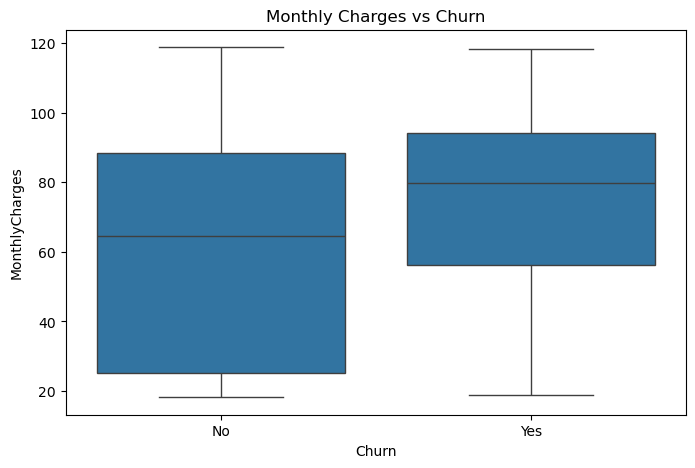

In [153]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.title("Monthly Charges vs Churn")
plt.show()


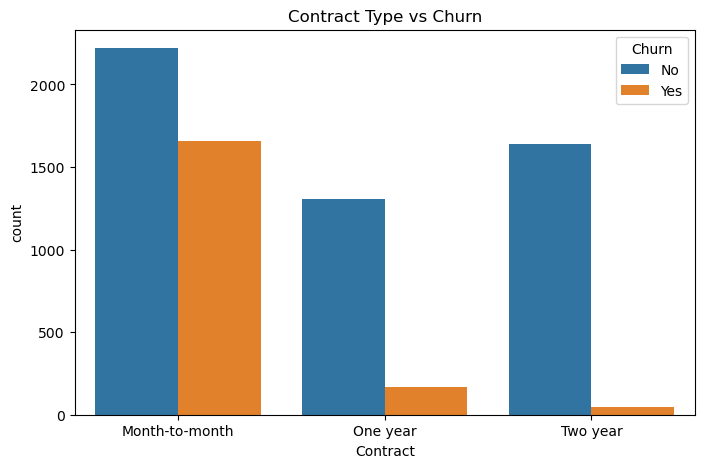

In [155]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Contract Type vs Churn")
plt.show()


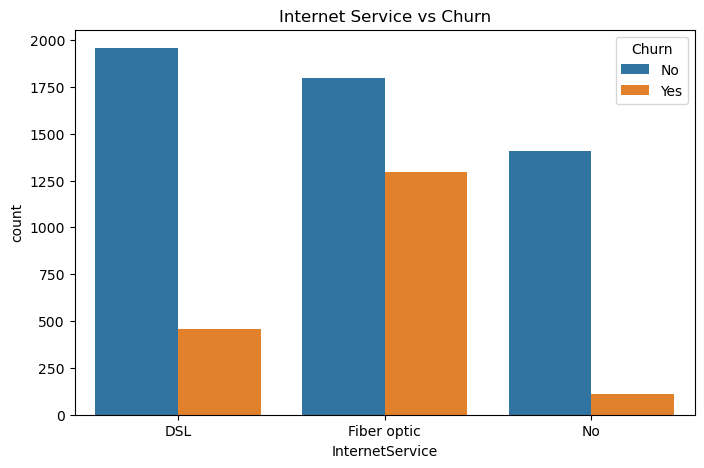

In [157]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title("Internet Service vs Churn")
plt.show()


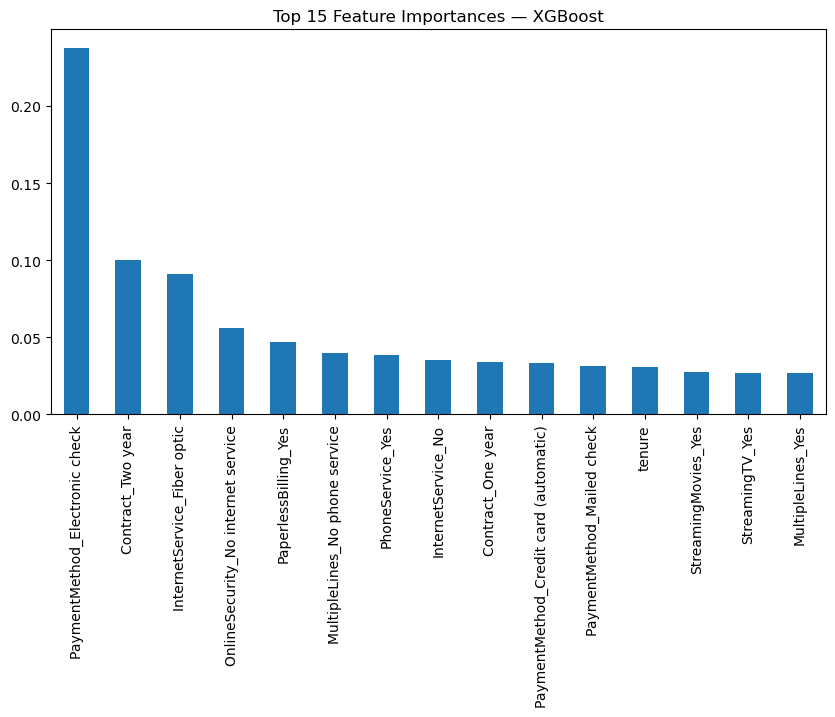

In [159]:
import pandas as pd

importance = pd.Series(xgb_bal.feature_importances_, index=X.columns)
importance.nlargest(15).plot(kind='bar', figsize=(10,5))
plt.title("Top 15 Feature Importances — XGBoost")
plt.show()


## 3. Data Preprocessing for Modeling

Before training machine learning models:
- Non-predictive column (`customerID`) is removed  
- Target variable `Churn` is encoded (No=0, Yes=1)  
- Categorical features are one-hot encoded  


In [161]:
df_model = df.drop(columns=["customerID"])
df_model["Churn"] = df_model["Churn"].map({"No": 0, "Yes": 1})

df_encoded = pd.get_dummies(df_model, drop_first=True)

df_encoded.head()


,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [163]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

y.value_counts()


Churn
0    5163
1    1869
Name: count, dtype: int64

## 4. Handling Class Imbalance Using SMOTE

The original dataset is imbalanced (more "No" churn than "Yes" churn).  
This can lead to poor model performance.

SMOTE (Synthetic Minority Oversampling Technique) is applied to balance the classes before training.



Before SMOTE:
 Churn
0    5163
1    1869
Name: count, dtype: int64

After SMOTE:
 Churn
0    5163
1    5163
Name: count, dtype: int64


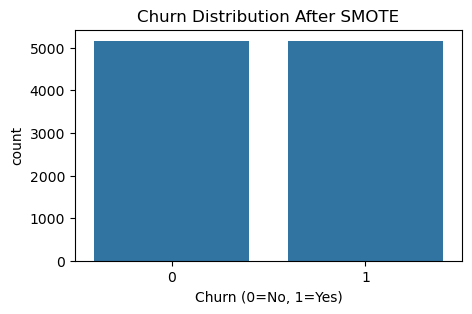

In [165]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("Before SMOTE:\n", y.value_counts())
print("\nAfter SMOTE:\n", y_res.value_counts())

# optional: visualize balanced y_res
plt.figure(figsize=(5,3))
sns.countplot(x=y_res)
plt.title("Churn Distribution After SMOTE")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.show()


## 5. Train-Test Split


In [193]:
# 7. Train-test split on SMOTE data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

X_train.shape, X_test.shape


((8260, 30), (2066, 30))

## 6. Model Training — Logistic Regression

Logistic Regression is used as a baseline model.  
Trained on the SMOTE-balanced dataset.


In [167]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log = LogisticRegression(max_iter=2000)
log.fit(X_train, y_train)

y_pred_log = log.predict(X_test)
print("Logistic Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Accuracy: 0.829622458857696
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1033
           1       0.82      0.85      0.83      1033

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066



C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 7. Model Training — XGBoost (Final Model)

XGBoost provided the best balance of accuracy and recall.  
This is selected as the final model.


In [177]:
# XGBoost (balanced)
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:34:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8344627299128751
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1033
           1       0.82      0.85      0.84      1033

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066



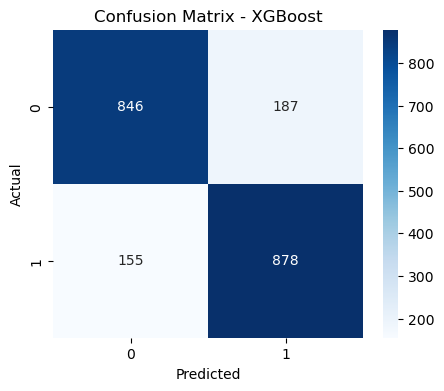

In [179]:
# Confusion matrix (example: for XGBoost)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


## 8. Feature Importance (XGBoost)

Analyzing top predictors of churn helps understand business drivers.


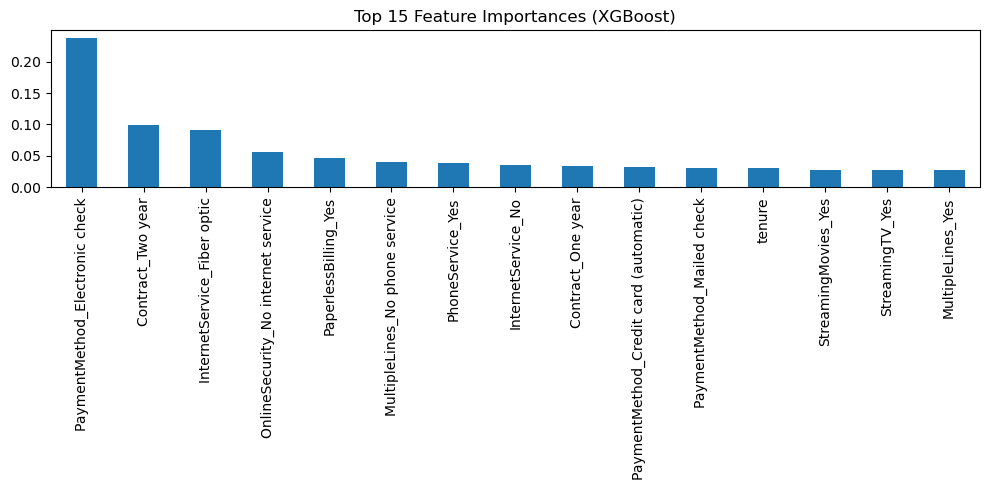

In [173]:
# Feature importance
import pandas as pd
importance = pd.Series(xgb.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
importance.sort_values(ascending=False).head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


## 9. Business Insights

### • Month-to-month contracts show the highest churn  
### • Customers with higher monthly charges churn more  
### • Low-tenure customers churn early  
### • Fiber optic customers have higher churn  
### • Electronic check payment method correlates with higher churn

These insights can help the company design customer retention strategies.


In [181]:
import os

# creating the 'models' folder
os.makedirs("models", exist_ok=True)


## 10. Saving the Final Model


In [183]:
import joblib

joblib.dump(xgb, "models/xgb_churn_model.pkl")
joblib.dump(list(X.columns), "models/model_features.pkl")


['models/model_features.pkl']

In [185]:
# Quick comparison helper 
results = {
    "Model": ["Logistic (balanced)", "XGBoost (balanced)"],
    "Accuracy": [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_xgb)],
    # compute recall for churn class (1)
    "Churn Recall": [
        classification_report(y_test, y_pred_log, output_dict=True)["1"]["recall"],
        classification_report(y_test, y_pred_xgb, output_dict=True)["1"]["recall"]
    ]
}
pd.DataFrame(results)


,Model,Accuracy,Churn Recall
0,Logistic (balanced),0.829622,0.846079
1,XGBoost (balanced),0.834463,0.849952
